In [169]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import napari
from skimage.data import cells3d
import time


def plane(X,Y,a,b,c):
    return a*X + b*Y + c

def create_test_volume(N,M):

    volume = np.empty((N,M,M))
    coef_volume = np.empty((N,3))

    Y, X = np.indices((M,M))
    Y = Y - M//2
    Y = Y/np.max(Y)
    X = X - M//2
    X = X/np.max(X)


    for i in range(0,N):
        a = np.random.rand(1)*1e-3
        b = np.random.rand(1)*1e-3
        c = np.random.rand(1)*1e-3
        coef_volume[i,0] = a
        coef_volume[i,1] = b
        coef_volume[i,2] = c
        volume[i] = plane(X,Y,a,b,c) 

    return volume, coef_volume

def calculate_gradients(data,X,Y,W,a,b,c):
    gradA = -2*np.sum(W*X*(W*data-(a*X+b*Y+c)))
    gradB = -2*np.sum(W*Y*(W*data-(a*X+b*Y+c)))
    gradC = -2*np.sum(W*(W*data-(a*X+b*Y+c)))
    return gradA, gradB, gradC

def gradient_descent_iteration(a,b,c,gradA, gradB, gradC,step_a,step_b, step_c):
    a = a - step_a * gradA
    b = b - step_b * gradB
    c = c - step_c * gradC
    return a, b, c


# Adam optimizer
def adam_iteration(params, grads, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1, m=None, v=None):
    if m is None:
        m = [np.zeros_like(p) for p in params]
    if v is None:
        v = [np.zeros_like(p) for p in params]
    
    new_params = []
    new_m = []
    new_v = []

    for p, g, m_t, v_t in zip(params, grads, m, v):
        m_t = beta1 * m_t + (1 - beta1) * g
        v_t = beta2 * v_t + (1 - beta2) * (g ** 2)

        m_hat = m_t / (1 - beta1 ** t)
        v_hat = v_t / (1 - beta2 ** t)

        p -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

        new_params.append(p)
        new_m.append(m_t)
        new_v.append(v_t)

    return new_params, new_m, new_v





In [170]:
N = 20
M = 256

volume, coef_volume = create_test_volume(N,M)
mask = np.ones_like(volume[0])

Y, X = np.indices((M,M))
Y = Y - M//2
Y = Y/np.max(Y)
X = X - M//2
X = X/np.max(X)

A = 50
mask[A:-A,A:-A] = 0

# viewer, image_layer = napari.imshow(volume)
# fig, ax = plt.subplots()
# ax.imshow(mask)

In [171]:
iterations = 20
step_a = step_b = step_c = 1e-5
init_a = init_b = init_c = 0
result = np.empty((volume.shape[0],3))

print('GD')
for i in range(0,volume.shape[0]):
    print('Slice ',i,end='\r')
    slice = volume[i]
    
    a,b,c = init_a, init_b, init_c
    for j in range(0,iterations):
        gradA, gradB, gradC = calculate_gradients(slice,X,Y,mask,a,b,c)
        a,b,c = gradient_descent_iteration(a,b,c,gradA, gradB, gradC,step_a,step_b, step_c)

    result[i,0] = a
    result[i,1] = b
    result[i,2] = c



result_adam = np.empty((volume.shape[0],3))

print('Adam')
for i in range(0,volume.shape[0]):
    print('Slice ',i,end='\r')
    slice = volume[i]

    m = v = None
    params = [init_a, init_b, init_c]    
    for j in range(0,iterations):
        grads = calculate_gradients(slice,X,Y,mask,params[0],params[1],params[2])
        params, m, v = adam_iteration(params, grads,m=m,v=v,lr=1e-3)

    result_adam[i,0] = params[0] # a
    result_adam[i,1] = params[1] # b
    result_adam[i,2] = params[2] # c




GD
Adame  19


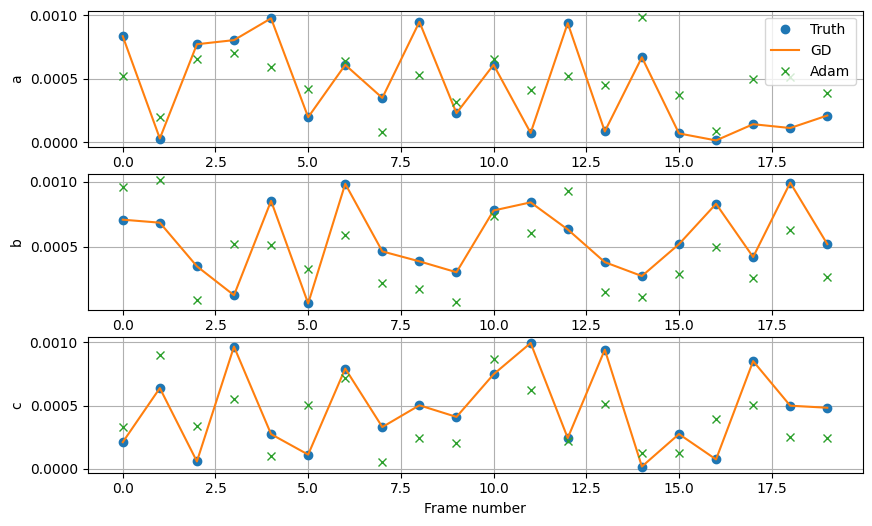

In [172]:
fig, ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(coef_volume[:,0],'o',label='Truth')
ax[1].plot(coef_volume[:,1],'o')
ax[2].plot(coef_volume[:,2],'o')


ax[0].plot(result[:,0],'-',label='GD')
ax[1].plot(result[:,1],'-')
ax[2].plot(result[:,2],'-')


ax[0].plot(result_adam[:,0],'x',label='Adam')
ax[1].plot(result_adam[:,1],'x')
ax[2].plot(result_adam[:,2],'x')


ax[0].set_ylabel('a'), ax[0].grid()
ax[1].set_ylabel('b'), ax[1].grid()
ax[2].set_ylabel('c'), ax[2].grid()
ax[2].set_xlabel('Frame number')
ax[0].legend()